In [0]:
from __future__ import print_function
import numpy as np
import random
np.random.seed(57)

In [0]:
#Abstract Class
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        return input
      
    def backward(self, input, grad_output):
        return np.dot(grad_output, np.eye(input.shape[1]))

In [0]:
class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Применить ReLU ко всем элементам input
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        #Вычисляем градиент в точке входа ( по правилу производной сложной функции)
        relu_grad = input > 0
        return grad_output*relu_grad

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        # Инициализируем веса случайными числами из нормального распределения
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        #Применм веса к входу по формуле Wx+b, где x - это input
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # Вычисляем df/d(input) = df/d(layer)*d(Layer)/d(input)
        # d(Layer)/d(input) = Транспонированные веса 
        grad_input = np.dot(grad_output, self.weights.T)
        
        # Вычисляем градиент по весам
        # Мы получили из предыдущего шага как должны измениться выходы на этого слоя. Это df/d(Layer)
        # Производная d(Layer)/d(Weights) = (input)T
        # Применяем ChainRule
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
         
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy
  
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


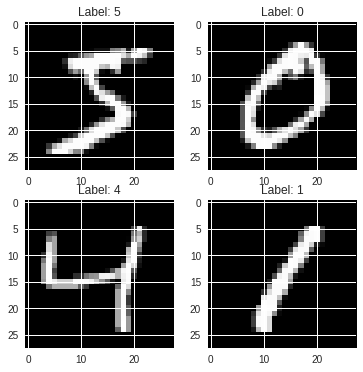

In [6]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    X_train = X_train.reshape([X_train.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_test, y_test
X_train, y_train, X_val, y_val = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    activations = []
    input = X
    for l in network:
        activations.append(l.forward(input))
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
  
def predict(network,X):
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Вычисляем ошибку и градиент ошибки
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Выполняем обратно распространение ошибки
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad)
        
    return np.mean(loss)

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



In [10]:
EPOCHS = 25
train_log = []
val_log = []
for epoch in range(EPOCHS):
    
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))

100%|██████████| 1875/1875 [00:05<00:00, 370.90it/s]


Точность на обучающей выборке: 0.9999833333333333
Точность на тествой выборке: 0.9817


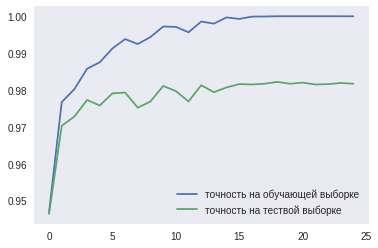

In [11]:
print("Точность на обучающей выборке:",train_log[-1])
print("Точность на тествой выборке:",val_log[-1])
plt.plot(train_log,label='точность на обучающей выборке')
plt.plot(val_log,label='точность на тествой выборке')
plt.legend(loc='best')
plt.grid()
plt.show()

In [0]:

m = 5

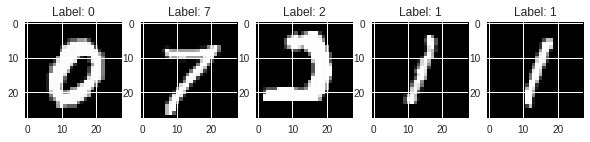

In [25]:
tester = random.sample(range(X_train.shape[0]), m)
f, ax = plt.subplots(1,len(tester), figsize=(10,10))
for i in range(len(tester)):
    ax[i].set_title("Label: %i"%predict(network,X_train[tester[i]]))
    ax[i].imshow(X_train[tester[i]].reshape([28,28]),cmap='gray');